In [65]:
%autosave 100

import numpy as np
import math
import matplotlib.pyplot as plt

Autosaving every 100 seconds


In [66]:
# step: 1 at(0, 5), 0 at(5, 10)
# Начальное распределение температуры
def func0(x):
    return 1 if x < 5 else 0

#    __
#   /  \
# _/    \_
def func1(x):
    if (x < 2):
        return 0
    elif (x < 4):
        return x / 2 - 1
    elif (x < 6):
        return 1
    elif (x < 8):
        return - x / 2 + 4
    else:
        return 0

In [67]:
# Явная схема против потока
def explicit_downstream(T_pred, r, s, i):
    return (r + s) * T_pred[i - 1] + (1 - 2 * r - s) * T_pred[i] + r * T_pred[i + 1]

# Явная схема по потоку
def explicit_upstream(T_pred, r, s, i):
    return r * T_pred[i - 1] + (1 - 2 * r + s) * T_pred[i] + (r - s) * T_pred[i + 1]

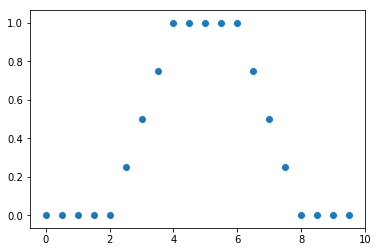

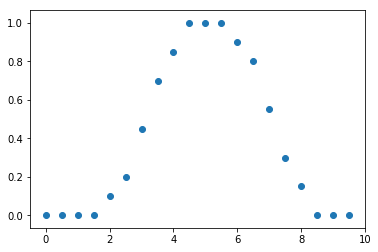

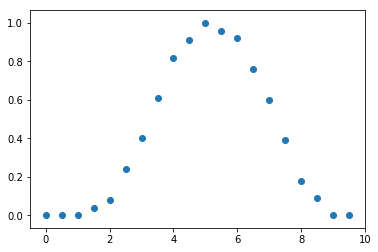

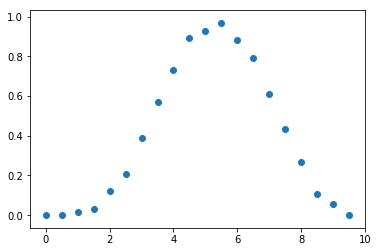

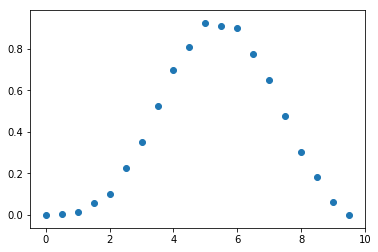

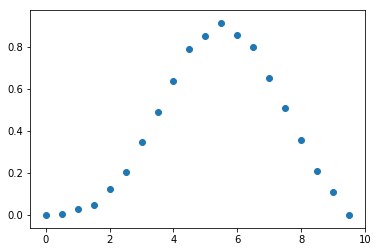

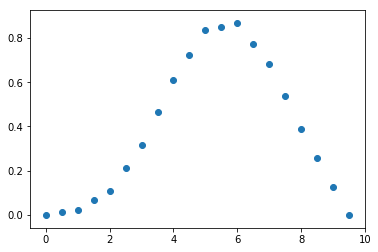

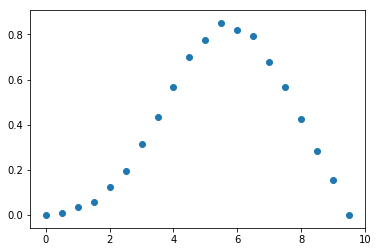

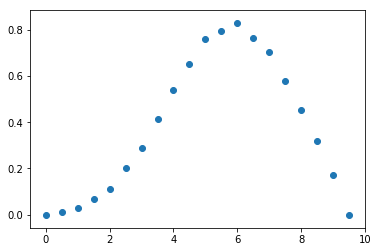

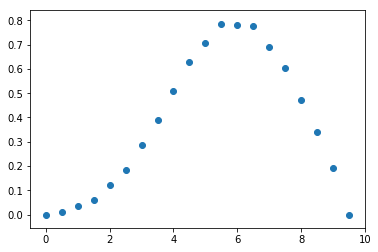

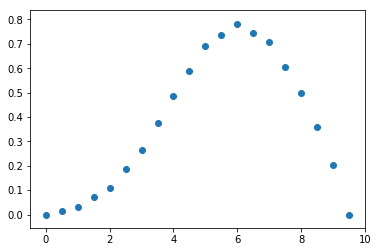

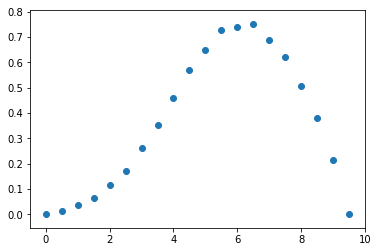

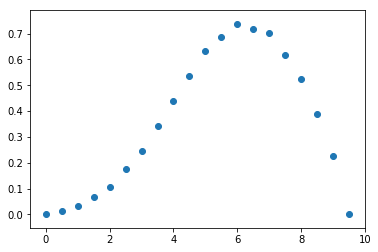

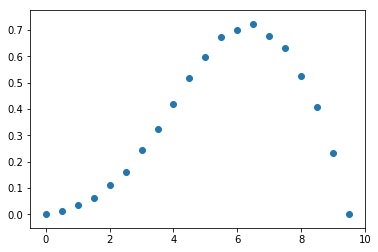

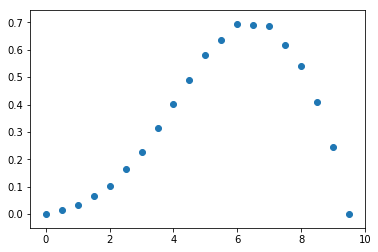

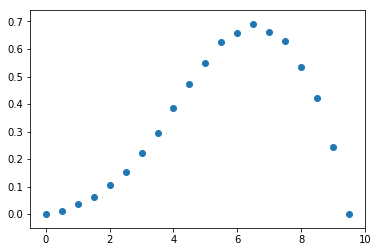

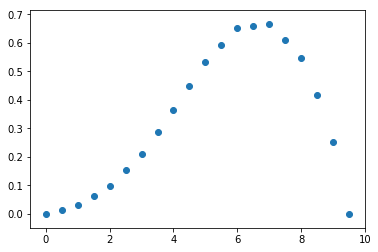

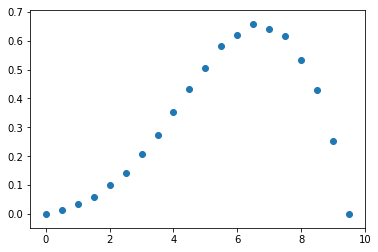

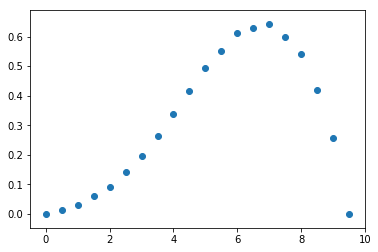

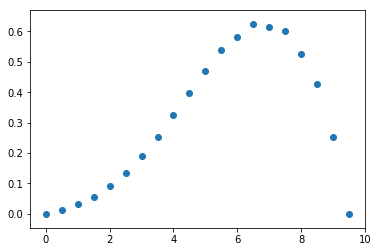

In [70]:
times = 20
dt = 1
dx = 0.5
u = 0.1
kappa = 0.1

steps = round(10 / dx)
s = u * dt / dx
r = kappa * dt / dx / dx

T = np.zeros([times, steps], dtype = float)
xs = np.arange(0, 10, dx)

for (i,x) in enumerate(xs):
    T[0,i] = func1(x)    
plt.scatter(xs, T[0,:])
plt.show()

for time in range(1, times):
    T[time, 0] = func1(0)
    for (i,x) in enumerate(xs):
        if (i == 0 or i == T.shape[1] - 1): continue
        T[time, i] = explicit_downstream(T[time - 1], r, s, i)
    T[time, T.shape[1] - 1] = func1(10)
    plt.scatter(xs, T[time,:])
    plt.show()
    